In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif' 

print("Libraries loaded.")

c:\Users\nakamura.keisuke\OneDrive\Documents\Python_Project\portfolio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded.


In [2]:
# Cell 2: Data Loading & Preprocessing
try:
    df = pd.read_csv('../data/simulated_hr_data.csv')
except FileNotFoundError:
    df = pd.read_csv('data/simulated_hr_data.csv')

# ID削除
df_analysis = df.drop(columns=['employee_id', 'month'])
df_encoded = pd.get_dummies(df_analysis, drop_first=True).dropna()

print(f"Data Loaded: {df_encoded.shape}")

Data Loaded: (40076, 18)


=== Estimating Causal Effect of Salary Change ===
Training Causal Forest for Salary Change... (This may take 1-2 mins)
Creating Heatmap...


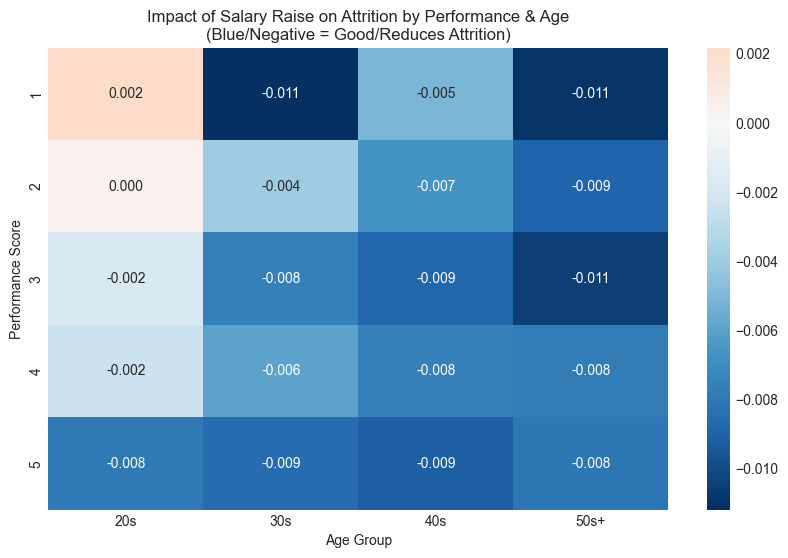

SUCCESS: Heterogeneity analysis completed.


In [3]:
# Cell 3: Causal Forest Analysis & Visualization
print("=== Estimating Causal Effect of Salary Change ===")

# 処置: salary_change_flag (給与改定有無)
T_salary = df_encoded['salary_change_flag']
Y = df_encoded['attrition_flag']

# 共変量 (給与改定自体と結果、他の施策を除外)
# training_participation も交絡要因として制御変数(X)に入れるべきですが、
# 今回は「給与の効果」を際立たせるため、特徴量として使います
drop_cols_salary = ['salary_change_flag', 'attrition_flag']
X_salary = df_encoded.drop(columns=drop_cols_salary)

# Causal Forestによる学習
print("Training Causal Forest for Salary Change... (This may take 1-2 mins)")
cf_salary = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    random_state=42
)

cf_salary.fit(Y, T_salary, X=X_salary)
cate_salary = cf_salary.effect(X_salary)

# 結果を結合
df_res = df.copy()
df_res['cate_salary'] = cate_salary

# ---------------------------------------------------------
# ターゲットセグメントの特定 (Who should get a raise?)
# ---------------------------------------------------------
print("Creating Heatmap...")

# 年代とパフォーマンスごとの「給与改定の効果(平均)」を集計
# cate_salaryが「マイナスに大きい」ほど、離職抑制効果が高い
df_res['AgeGroup'] = pd.cut(df_res['age'], bins=[20, 30, 40, 50, 65], labels=['20s', '30s', '40s', '50s+'])
pivot_table = df_res.pivot_table(
    index='performance_score', 
    columns='AgeGroup', 
    values='cate_salary', 
    aggfunc='mean'
)

# ヒートマップで可視化
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdBu_r', center=0)
plt.title('Impact of Salary Raise on Attrition by Performance & Age\n(Blue/Negative = Good/Reduces Attrition)')
plt.xlabel('Age Group')
plt.ylabel('Performance Score')
plt.show()

print("SUCCESS: Heterogeneity analysis completed.")